# Method 5 - Best Ideas High Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[best_ideas['size_pct'] > (2 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

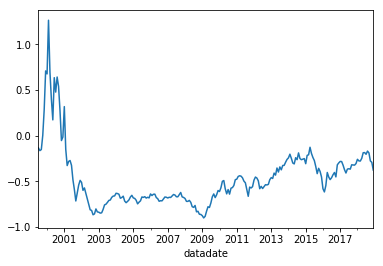

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.709264
2000-12-31   -0.423026
2001-12-31   -0.481000
2002-12-31   -0.674250
2003-12-31    1.048962
2004-12-31    0.019417
2005-12-31   -0.080318
2006-12-31    0.021770
2007-12-31   -0.006450
2008-12-31   -0.572294
2009-12-31    1.880941
2010-12-31    0.297224
2011-12-31   -0.147369
2012-12-31    0.172238
2013-12-31    0.426434
2014-12-31    0.012105
2015-12-31   -0.268389
2016-12-31    0.281023
2017-12-31   -0.009823
2018-12-31   -0.102738
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     193.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.35e-72
Time:                        04:29:45   Log-Likelihood:                 320.78
No. Observations:                 234   AIC:                            -631.6
Df Residuals:                     229   BIC:                            -614.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.004      0.972      0.332      -0.004       0.012
mktrf          1.3956      0.116     12.049      0.000       1.167       1.624
me             0.7956      0.135      5.905      0.000       0.530       1.061
ia            -0.3993      0.205     -1.950      0.052      -0.803       0.004
roe           -1.6231      0.175     -9.260      0.000      -1.968      -1.278
==============================================================================
Omnibus:                      132.902   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1467.771
Skew:                           1.975   Prob(JB):                         0.00
Kurtosis:                      14.616   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     115.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.44e-54
Time:                        04:29:45   Log-Likelihood:                 320.78
No. Observations:                 234   AIC:                            -631.6
Df Residuals:                     229   BIC:                            -614.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.004      0.985      0.325      -0.004       0.012
mktrf          1.3956      0.214      6.510      0.000       0.975       1.816
me             0.7956      0.181      4.393      0.000       0.441       1.151
ia            -0.3993      0.267     -1.494      0.135      -0.923       0.124
roe           -1.6231      0.233     -6.968      0.000      -2.080      -1.167
==============================================================================
Omnibus:                      132.902   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1467.771
Skew:                           1.975   Prob(JB):                         0.00
Kurtosis:                      14.616   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     152.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.76e-63
Time:                        04:29:45   Log-Likelihood:                 320.78
No. Observations:                 234   AIC:                            -631.6
Df Residuals:                     229   BIC:                            -614.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.005      0.910      0.363      -0.005       0.013
mktrf          1.3956      0.212      6.595      0.000       0.981       1.810
me             0.7956      0.185      4.309      0.000       0.434       1.157
ia            -0.3993      0.269     -1.482      0.138      -0.927       0.129
roe           -1.6231      0.246     -6.590      0.000      -2.106      -1.140
==============================================================================
Omnibus:                      132.902   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1467.771
Skew:                           1.975   Prob(JB):                         0.00
Kurtosis:                      14.616   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     145.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.56e-69
Time:                        04:29:45   Log-Likelihood:                 315.75
No. Observations:                 234   AIC:                            -619.5
Df Residuals:                     228   BIC:                            -598.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.004      0.765      0.445      -0.005       0.012
mktrf          1.5493      0.119     13.037      0.000       1.315       1.783
smb            0.8034      0.157      5.124      0.000       0.494       1.112
hml            0.1037      0.185      0.561      0.576      -0.261       0.468
rmw           -1.5667      0.209     -7.495      0.000      -1.979      -1.155
cma           -0.1237      0.266     -0.466      0.642      -0.647       0.400
==============================================================================
Omnibus:                      126.034   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              910.210
Skew:                           2.013   Prob(JB):                    2.24e-198
Kurtosis:                      11.784   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     126.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.22e-63
Time:                        04:29:45   Log-Likelihood:                 315.75
No. Observations:                 234   AIC:                            -619.5
Df Residuals:                     228   BIC:                            -598.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.004      0.775      0.438      -0.005       0.012
mktrf          1.5493      0.150     10.351      0.000       1.256       1.843
smb            0.8034      0.160      5.018      0.000       0.490       1.117
hml            0.1037      0.287      0.361      0.718      -0.460       0.667
rmw           -1.5667      0.225     -6.969      0.000      -2.007      -1.126
cma           -0.1237      0.314     -0.394      0.693      -0.739       0.491
==============================================================================
Omnibus:                      126.034   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              910.210
Skew:                           2.013   Prob(JB):                    2.24e-198
Kurtosis:                      11.784   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     139.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.29e-67
Time:                        04:29:45   Log-Likelihood:                 315.75
No. Observations:                 234   AIC:                            -619.5
Df Residuals:                     228   BIC:                            -598.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.005      0.715      0.475      -0.006       0.013
mktrf          1.5493      0.137     11.350      0.000       1.282       1.817
smb            0.8034      0.157      5.130      0.000       0.496       1.110
hml            0.1037      0.239      0.433      0.665      -0.365       0.573
rmw           -1.5667      0.229     -6.829      0.000      -2.016      -1.117
cma           -0.1237      0.270     -0.459      0.646      -0.652       0.405
==============================================================================
Omnibus:                      126.034   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              910.210
Skew:                           2.013   Prob(JB):                    2.24e-198
Kurtosis:                      11.784   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     170.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.30e-67
Time:                        04:29:45   Log-Likelihood:                 309.37
No. Observations:                 234   AIC:                            -608.7
Df Residuals:                     229   BIC:                            -591.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.004     -0.476      0.635      -0.011       0.006
mktrf          1.7046      0.112     15.224      0.000       1.484       1.925
smb            1.5239      0.140     10.904      0.000       1.249       1.799
hml           -0.3365      0.139     -2.423      0.016      -0.610      -0.063
umd           -0.5316      0.091     -5.836      0.000      -0.711      -0.352
==============================================================================
Omnibus:                      111.858   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              835.761
Skew:                           1.711   Prob(JB):                    3.29e-182
Kurtosis:                      11.603   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     70.46
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.12e-39
Time:                        04:29:45   Log-Likelihood:                 309.37
No. Observations:                 234   AIC:                            -608.7
Df Residuals:                     229   BIC:                            -591.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.004     -0.514      0.607      -0.010       0.006
mktrf          1.7046      0.184      9.283      0.000       1.345       2.064
smb            1.5239      0.178      8.584      0.000       1.176       1.872
hml           -0.3365      0.217     -1.547      0.122      -0.763       0.090
umd           -0.5316      0.146     -3.629      0.000      -0.819      -0.244
==============================================================================
Omnibus:                      111.858   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              835.761
Skew:                           1.711   Prob(JB):                    3.29e-182
Kurtosis:                      11.603   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     74.03
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.54e-40
Time:                        04:29:45   Log-Likelihood:                 309.37
No. Observations:                 234   AIC:                            -608.7
Df Residuals:                     229   BIC:                            -591.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.004     -0.490      0.624      -0.010       0.006
mktrf          1.7046      0.177      9.608      0.000       1.357       2.052
smb            1.5239      0.159      9.570      0.000       1.212       1.836
hml           -0.3365      0.212     -1.591      0.112      -0.751       0.078
umd           -0.5316      0.151     -3.517      0.000      -0.828      -0.235
==============================================================================
Omnibus:                      111.858   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              835.761
Skew:                           1.711   Prob(JB):                    3.29e-182
Kurtosis:                      11.603   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     98.79
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.85e-36
Time:                        04:29:45   Log-Likelihood:                 145.36
No. Observations:                 120   AIC:                            -280.7
Df Residuals:                     115   BIC:                            -266.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.007      0.885      0.378      -0.008       0.020
mktrf          1.2610      0.190      6.646      0.000       0.885       1.637
me             0.7952      0.187      4.244      0.000       0.424       1.166
ia            -0.7899      0.293     -2.692      0.008      -1.371      -0.209
roe           -1.5676      0.260     -6.036      0.000      -2.082      -1.053
==============================================================================
Omnibus:                       67.741   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              418.020
Skew:                           1.811   Prob(JB):                     1.69e-91
Kurtosis:                      11.395   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     128.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.76e-41
Time:                        04:29:45   Log-Likelihood:                 145.36
No. Observations:                 120   AIC:                            -280.7
Df Residuals:                     115   BIC:                            -266.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.006      0.982      0.326      -0.006       0.019
mktrf          1.2610      0.341      3.697      0.000       0.592       1.929
me             0.7952      0.229      3.466      0.001       0.346       1.245
ia            -0.7899      0.347     -2.278      0.023      -1.469      -0.110
roe           -1.5676      0.334     -4.694      0.000      -2.222      -0.913
==============================================================================
Omnibus:                       67.741   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              418.020
Skew:                           1.811   Prob(JB):                     1.69e-91
Kurtosis:                      11.395   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     262.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.46e-57
Time:                        04:29:45   Log-Likelihood:                 145.36
No. Observations:                 120   AIC:                            -280.7
Df Residuals:                     115   BIC:                            -266.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.007      0.956      0.339      -0.007       0.019
mktrf          1.2610      0.343      3.676      0.000       0.589       1.933
me             0.7952      0.233      3.414      0.001       0.339       1.252
ia            -0.7899      0.307     -2.571      0.010      -1.392      -0.188
roe           -1.5676      0.374     -4.193      0.000      -2.300      -0.835
==============================================================================
Omnibus:                       67.741   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              418.020
Skew:                           1.811   Prob(JB):                     1.69e-91
Kurtosis:                      11.395   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     79.68
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.45e-35
Time:                        04:29:45   Log-Likelihood:                 146.14
No. Observations:                 120   AIC:                            -280.3
Df Residuals:                     114   BIC:                            -263.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0070      0.007      0.975      0.332      -0.007       0.021
mktrf          1.6203      0.200      8.117      0.000       1.225       2.016
smb            0.8933      0.226      3.951      0.000       0.445       1.341
hml           -0.3699      0.277     -1.335      0.185      -0.919       0.179
rmw           -1.1652      0.327     -3.566      0.001      -1.812      -0.518
cma           -0.1414      0.358     -0.395      0.694      -0.850       0.568
==============================================================================
Omnibus:                       71.382   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              351.310
Skew:                           2.059   Prob(JB):                     5.18e-77
Kurtosis:                      10.301   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     93.94
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.05e-39
Time:                        04:29:45   Log-Likelihood:                 146.14
No. Observations:                 120   AIC:                            -280.3
Df Residuals:                     114   BIC:                            -263.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0070      0.006      1.224      0.221      -0.004       0.018
mktrf          1.6203      0.270      6.007      0.000       1.092       2.149
smb            0.8933      0.230      3.889      0.000       0.443       1.343
hml           -0.3699      0.219     -1.685      0.092      -0.800       0.060
rmw           -1.1652      0.317     -3.679      0.000      -1.786      -0.544
cma           -0.1414      0.349     -0.406      0.685      -0.825       0.542
==============================================================================
Omnibus:                       71.382   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              351.310
Skew:                           2.059   Prob(JB):                     5.18e-77
Kurtosis:                      10.301   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     107.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.94e-41
Time:                        04:29:45   Log-Likelihood:                 146.14
No. Observations:                 120   AIC:                            -280.3
Df Residuals:                     114   BIC:                            -263.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0070      0.006      1.164      0.245      -0.005       0.019
mktrf          1.6203      0.231      7.013      0.000       1.167       2.073
smb            0.8933      0.207      4.305      0.000       0.487       1.300
hml           -0.3699      0.161     -2.294      0.022      -0.686      -0.054
rmw           -1.1652      0.329     -3.544      0.000      -1.810      -0.521
cma           -0.1414      0.275     -0.514      0.607      -0.680       0.397
==============================================================================
Omnibus:                       71.382   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              351.310
Skew:                           2.059   Prob(JB):                     5.18e-77
Kurtosis:                      10.301   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     106.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.97e-38
Time:                        04:29:45   Log-Likelihood:                 148.99
No. Observations:                 120   AIC:                            -288.0
Df Residuals:                     115   BIC:                            -274.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.007      0.217      0.828      -0.012       0.015
mktrf          1.7181      0.162     10.595      0.000       1.397       2.039
smb            1.4967      0.185      8.106      0.000       1.131       1.862
hml           -0.7112      0.185     -3.846      0.000      -1.078      -0.345
umd           -0.4839      0.114     -4.244      0.000      -0.710      -0.258
==============================================================================
Omnibus:                       64.096   Durbin-Watson:                   1.768
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              397.578
Skew:                           1.682   Prob(JB):                     4.65e-87
Kurtosis:                      11.259   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     94.40
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.12e-35
Time:                        04:29:46   Log-Likelihood:                 148.99
No. Observations:                 120   AIC:                            -288.0
Df Residuals:                     115   BIC:                            -274.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.006      0.246      0.806      -0.010       0.013
mktrf          1.7181      0.271      6.346      0.000       1.187       2.249
smb            1.4967      0.189      7.908      0.000       1.126       1.868
hml           -0.7112      0.240     -2.966      0.003      -1.181      -0.241
umd           -0.4839      0.158     -3.071      0.002      -0.793      -0.175
==============================================================================
Omnibus:                       64.096   Durbin-Watson:                   1.768
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              397.578
Skew:                           1.682   Prob(JB):                     4.65e-87
Kurtosis:                      11.259   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     210.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.51e-52
Time:                        04:29:46   Log-Likelihood:                 148.99
No. Observations:                 120   AIC:                            -288.0
Df Residuals:                     115   BIC:                            -274.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.006      0.240      0.810      -0.010       0.013
mktrf          1.7181      0.263      6.539      0.000       1.203       2.233
smb            1.4967      0.153      9.814      0.000       1.198       1.796
hml           -0.7112      0.188     -3.780      0.000      -1.080      -0.342
umd           -0.4839      0.171     -2.821      0.005      -0.820      -0.148
==============================================================================
Omnibus:                       64.096   Durbin-Watson:                   1.768
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              397.578
Skew:                           1.682   Prob(JB):                     4.65e-87
Kurtosis:                      11.259   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     103.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.85e-36
Time:                        04:29:46   Log-Likelihood:                 192.95
No. Observations:                 114   AIC:                            -375.9
Df Residuals:                     109   BIC:                            -362.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.005      0.240      0.810      -0.008       0.010
mktrf          1.5718      0.134     11.738      0.000       1.306       1.837
me             0.6454      0.207      3.122      0.002       0.236       1.055
ia             0.3543      0.287      1.235      0.219      -0.214       0.923
roe           -1.8324      0.252     -7.272      0.000      -2.332      -1.333
==============================================================================
Omnibus:                       14.282   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.206
Skew:                           0.628   Prob(JB):                     4.10e-05
Kurtosis:                       4.636   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     78.52
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.30e-31
Time:                        04:29:46   Log-Likelihood:                 192.95
No. Observations:                 114   AIC:                            -375.9
Df Residuals:                     109   BIC:                            -362.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.004      0.306      0.760      -0.006       0.008
mktrf          1.5718      0.165      9.530      0.000       1.249       1.895
me             0.6454      0.289      2.233      0.026       0.079       1.212
ia             0.3543      0.322      1.101      0.271      -0.277       0.985
roe           -1.8324      0.422     -4.345      0.000      -2.659      -1.006
==============================================================================
Omnibus:                       14.282   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.206
Skew:                           0.628   Prob(JB):                     4.10e-05
Kurtosis:                       4.636   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     89.45
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.60e-33
Time:                        04:29:46   Log-Likelihood:                 192.95
No. Observations:                 114   AIC:                            -375.9
Df Residuals:                     109   BIC:                            -362.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.003      0.328      0.743      -0.005       0.008
mktrf          1.5718      0.159      9.872      0.000       1.260       1.884
me             0.6454      0.326      1.978      0.048       0.006       1.285
ia             0.3543      0.348      1.018      0.309      -0.328       1.037
roe           -1.8324      0.423     -4.328      0.000      -2.662      -1.003
==============================================================================
Omnibus:                       14.282   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.206
Skew:                           0.628   Prob(JB):                     4.10e-05
Kurtosis:                       4.636   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     77.40
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.25e-34
Time:                        04:29:46   Log-Likelihood:                 190.16
No. Observations:                 114   AIC:                            -368.3
Df Residuals:                     108   BIC:                            -351.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.005     -0.321      0.749      -0.011       0.008
mktrf          1.6098      0.131     12.245      0.000       1.349       1.870
smb            0.5958      0.213      2.792      0.006       0.173       1.019
hml            0.9321      0.272      3.424      0.001       0.393       1.472
rmw           -1.5658      0.333     -4.698      0.000      -2.226      -0.905
cma           -0.1522      0.423     -0.360      0.720      -0.991       0.686
==============================================================================
Omnibus:                       25.487   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.030
Skew:                           0.654   Prob(JB):                     1.04e-20
Kurtosis:                       7.203   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     75.03
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.56e-33
Time:                        04:29:46   Log-Likelihood:                 190.16
No. Observations:                 114   AIC:                            -368.3
Df Residuals:                     108   BIC:                            -351.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.005     -0.320      0.749      -0.011       0.008
mktrf          1.6098      0.127     12.667      0.000       1.361       1.859
smb            0.5958      0.211      2.822      0.005       0.182       1.010
hml            0.9321      0.218      4.281      0.000       0.505       1.359
rmw           -1.5658      0.393     -3.981      0.000      -2.337      -0.795
cma           -0.1522      0.342     -0.445      0.656      -0.823       0.518
==============================================================================
Omnibus:                       25.487   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.030
Skew:                           0.654   Prob(JB):                     1.04e-20
Kurtosis:                       7.203   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     99.51
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.58e-39
Time:                        04:29:46   Log-Likelihood:                 190.16
No. Observations:                 114   AIC:                            -368.3
Df Residuals:                     108   BIC:                            -351.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.004     -0.340      0.734      -0.010       0.007
mktrf          1.6098      0.135     11.937      0.000       1.345       1.874
smb            0.5958      0.227      2.628      0.009       0.152       1.040
hml            0.9321      0.187      4.974      0.000       0.565       1.299
rmw           -1.5658      0.367     -4.263      0.000      -2.286      -0.846
cma           -0.1522      0.349     -0.436      0.663      -0.836       0.532
==============================================================================
Omnibus:                       25.487   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.030
Skew:                           0.654   Prob(JB):                     1.04e-20
Kurtosis:                       7.203   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     84.38
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.77e-32
Time:                        04:29:46   Log-Likelihood:                 183.76
No. Observations:                 114   AIC:                            -357.5
Df Residuals:                     109   BIC:                            -343.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.005     -0.584      0.561      -0.013       0.007
mktrf          1.6614      0.138     12.079      0.000       1.389       1.934
smb            0.9620      0.214      4.485      0.000       0.537       1.387
hml            0.8403      0.221      3.804      0.000       0.402       1.278
umd           -0.5265      0.167     -3.160      0.002      -0.857      -0.196
==============================================================================
Omnibus:                       30.356   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.460
Skew:                           0.828   Prob(JB):                     1.70e-24
Kurtosis:                       7.506   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     92.04
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.86e-34
Time:                        04:29:46   Log-Likelihood:                 183.76
No. Observations:                 114   AIC:                            -357.5
Df Residuals:                     109   BIC:                            -343.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.004     -0.677      0.498      -0.011       0.005
mktrf          1.6614      0.143     11.654      0.000       1.382       1.941
smb            0.9620      0.226      4.255      0.000       0.519       1.405
hml            0.8403      0.235      3.577      0.000       0.380       1.301
umd           -0.5265      0.145     -3.624      0.000      -0.811      -0.242
==============================================================================
Omnibus:                       30.356   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.460
Skew:                           0.828   Prob(JB):                     1.70e-24
Kurtosis:                       7.506   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     105.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.77e-36
Time:                        04:29:46   Log-Likelihood:                 183.76
No. Observations:                 114   AIC:                            -357.5
Df Residuals:                     109   BIC:                            -343.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.004     -0.724      0.469      -0.011       0.005
mktrf          1.6614      0.142     11.717      0.000       1.383       1.939
smb            0.9620      0.214      4.492      0.000       0.542       1.382
hml            0.8403      0.240      3.505      0.000       0.370       1.310
umd           -0.5265      0.139     -3.792      0.000      -0.799      -0.254
==============================================================================
Omnibus:                       30.356   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.460
Skew:                           0.828   Prob(JB):                     1.70e-24
Kurtosis:                       7.506   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""